# Regression Model Comparison - Student Performance

## Objective
Evaluate and compare regression models to predict exam scores, balancing predictive accuracy, stability, and computational efficiency.


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# pipelines e transformadores
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer

# codificação de variáveis
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

# normalização
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# dados faltantes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# modelagem
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, KFold, ShuffleSplit, RandomizedSearchCV

## Reading the dataset and creating the data dictionary

In [ ]:
df = pd.read_csv('https://github.com/atlantico-academy/datasets/raw/main/student_habits_performance.csv')

df_dict = pd.DataFrame([
    {
        "variavel": "student_id",
        "descricao": "identificação do estudante",
        "tipo": "inútil",
        "subtipo": "-",
    },
    {
        "variavel": "age",
        "descricao": "idade do aluno",
        "tipo": "quantitativa",
        "subtipo": "discreta",
    },
    {
        "variavel": "gender",
        "descricao": "Gênero do aluno (Male/Female/Other).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "study_hours_per_day",
        "descricao": "Indica quantas horas estuda/dia.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "social_media_hours",
        "descricao": "Indica quantas horas utiliza a rede social.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "netflix_hours",
        "descricao": "Indica quantas horas utiliza a Netflix.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "part_time_job",
        "descricao": "trabalha meio período (Yes/No).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "attendance_percentage",
        "descricao": "Porcentagem de presença nas aulas.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "sleep_hours",
        "descricao": "Horas de sono por dia.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "diet_quality",
        "descricao": "Qualidade da dieta (Poor, Fair, Good, Excellent).",
        "tipo": "qualitativa",
        "subtipo": "ordinal",
    },
    {
        "variavel": "exercise_frequency",
        "descricao": "Frequência de exercício por semana.",
        "tipo": "quantitativa",
        "subtipo": "discreta",
    },
    {
        "variavel": "parental_education_level",
        "descricao": "Nível de escolaridade dos pais (High School, Bachelor, Master, PhD).",
        "tipo": "qualitativa",
        "subtipo": "ordinal",
    },
    {
        "variavel": "internet_quality",
        "descricao": "Qualidade da internet (Poor, Average, Good).",
        "tipo": "qualitativa",
        "subtipo": "ordinal",
    },
    {
        "variavel": "mental_health_rating",
        "descricao": "Avaliação da saúde mental em uma escala de 1 a 10.",
        "tipo": "quantitativa",
        "subtipo": "discreta",
    },
    {
        "variavel": "extracurricular_participation",
        "descricao": "Participação em atividades extracurriculares (Yes/No).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "exam_score",
        "descricao": "Nota no exame.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    }
])
df_dict


,variavel,descricao,tipo,subtipo
0,student_id,identificação do estudante,inútil,-
1,age,idade do aluno,quantitativa,discreta
2,gender,Gênero do aluno (Male/Female/Other).,qualitativa,nominal
3,study_hours_per_day,Indica quantas horas estuda/dia.,quantitativa,contínua
4,social_media_hours,Indica quantas horas utiliza a rede social.,quantitativa,contínua
5,netflix_hours,Indica quantas horas utiliza a Netflix.,quantitativa,contínua
6,part_time_job,trabalha meio período (Yes/No).,qualitativa,nominal
7,attendance_percentage,Porcentagem de presença nas aulas.,quantitativa,contínua
8,sleep_hours,Horas de sono por dia.,quantitativa,contínua
9,diet_quality,"Qualidade da dieta (Poor, Fair, Good, Excellent).",qualitativa,ordinal


## Variable selection and separation of inputs and outputs

In [ ]:
target_variable = ['exam_score']
useless_variables =  (
    df_dict
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)
unused_variables = useless_variables + target_variable
nominal_variables = (
    df_dict
    .query("subtipo == 'nominal' and variavel not in @unused_variables")
    .variavel
    .to_list()
)
ordinal_variables = (
    df_dict
    .query("subtipo == 'ordinal' and variavel not in @unused_variables")
    .variavel
    .to_list()
)
continuous_variables = (
    df_dict
    .query("subtipo == 'contínua' and variavel not in @unused_variables")
    .variavel
    .to_list()
)
discrete_variables = (
    df_dict
    .query("subtipo == 'discreta' and variavel not in @unused_variables")
    .variavel
    .to_list()
)

X = df.drop(columns=unused_variables)
y = df[target_variable]

## Data preparation

Each type of variable underwent a specific data processing flow, namely:

### Quantitative variables
 - **Continuous**: imputation of missing values using the mean and min-max normalization.
 - **Discrete**: imputation of missing values using the median and min-max normalization.

### Qualitative variables
 - **Ordinal**: imputation of missing values using the mode and one-hot encoding.
 - **Nominal**: imputation of missing values based on the most frequent value and ordinal encoding of values.

In [ ]:
# variáveis discretas
discrete_preprocessing = Pipeline(steps=[
    ('missing', SimpleImputer(strategy='median')), # tratamento de dados faltantes
    ('normalization', MinMaxScaler()) # normalização
])

# variáveis contínuas
continuous_preprocessing = Pipeline(steps=[
    ('missing', SimpleImputer(strategy='mean')), # tratamento de dados faltantes
    ('normalization', MinMaxScaler()) # normalização
])

# variáveis ordinal
# 1. Definição das ordens corretas para cada variável
diet_order = ['Poor', 'Fair', 'Good', 'Excellent']
education_order = ['High School', 'Bachelor', 'Master', 'PhD']
internet_order = ['Poor', 'Average', 'Good']
# 2. Criação do pipeline com as categorias corretas
ordinal_preprocessing = Pipeline(steps=[
    ('missing', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder(categories=[
        diet_order,
        education_order,
        internet_order
    ]))
])

# variáveis nominais
nominal_preprocessing = Pipeline(steps=[
    ('missing', SimpleImputer(strategy='most_frequent')), # tratamento de dados faltantes
    ('encoding', OneHotEncoder(sparse_output=False, drop='if_binary'))
])

from sklearn.compose import ColumnTransformer

# Este objeto vai aplicar cada pipeline à sua respectiva coluna
preprocessor = ColumnTransformer(
    transformers=[
        ('discrete', discrete_preprocessing, discrete_variables),
        ('continuous', continuous_preprocessing, continuous_variables),
        ('ordinal', ordinal_preprocessing, ordinal_variables),
        ('nominal', nominal_preprocessing, nominal_variables)
    ],
    remainder='passthrough'
)

print("Pré-processador criado com sucesso!")

Pré-processador criado com sucesso!


## Cross-validation

We will analyze four models, which will be tested using Monte Carlo cross-validation with 30 repetitions. The models used in the analysis are:

- Linear regression
- K-nearest neighbors
- Support Vector Machine
- Decision Tree

In addition, each of these algorithms will be tested with different hyperparameters so that we can find the best model and the best possible configuration for that model. This optimization will be performed using k-fold cross-validation from the training data.

We will use the following metrics for analysis:
- **Mean absolute error (MAE)**: measures the mean absolute error between actual and predicted values. It has a direct interpretation in units of the target variable.
 - **Mean squared error (MSE)**: penalizes large errors more heavily (because it squares them).
- **Coefficient of determination (R² score)**: measures how much the model can reduce the error compared to the data average. It ranges from minus infinity to 1. A good model tends to have values close to 1.
- **Mean absolute percentage error (MAPE)**: measures the mean percentage error. It is more suitable when we have values of different scales.

In [1]:
# @title Model Implementation
preprocessing = ColumnTransformer(transformers=[
    ("ordinal", ordinal_preprocessing, ordinal_variables),
    ("nominal", nominal_preprocessing, nominal_variables),
    ("discrete", discrete_preprocessing, discrete_variables),
    ("continuous", continuous_preprocessing, continuous_variables),
], remainder='passthrough')

modelos = [
    {
        "nome": "LRG",
        "objeto": LinearRegression(),
        "hp": {}
    }, {
        "nome": "KNN",
        "objeto": KNeighborsRegressor(),
        "hp": {
            'n_neighbors': np.arange(1, 31, 5), # Número de vizinhos entre 1 e 30
            'weights': ['uniform', 'distance'], # Peso uniforme ou baseado na distância
            'p': [1, 2] # Distância de Manhattan (p=1) ou Euclidiana (p=2)
        }
    }, {
        "nome": "DTR",
        "objeto": DecisionTreeRegressor(random_state=42),
        "hp": {
            'max_depth': [None] + list(np.arange(2, 20, 4)), # Profundidade máxima
            'max_features': [None, 'sqrt', 'log2'] # Máximo de features
        }
    }, {
        "nome": "SVR",
        "objeto": SVR(),
        "hp": {
            'C': np.logspace(-3, 3, 10),     # Regularização
            'epsilon': np.logspace(-4, 0, 10),  # Insensibilidade à margem
            'kernel': ['linear', 'rbf', 'sigmoid'],  # Kernel a ser usado
        }
    }
]

NameError: name 'ColumnTransformer' is not defined

In [ ]:
# @title Cross Validation Execution
cv = ShuffleSplit(n_splits=30, test_size=.2, random_state=42)
metrics = {
    'neg_mean_absolute_error': 'MAE',
    'neg_mean_squared_error': 'MSE',
    'r2': 'R2',
    'neg_mean_absolute_percentage_error': 'MAPE'
}

results = []
# aplica validação cruzada em todos os modelos
for modelo in modelos:
    # aplicar random search
    random_search = RandomizedSearchCV(
        estimator=modelo["objeto"],
        param_distributions=modelo["hp"],
        n_iter=1 if modelo["nome"] == "LRG" else 10, # Número de combinações de parâmetros a testar
        scoring='neg_mean_squared_error',  # Métrica de avaliação
        cv=5, # Número de divisões para validação cruzada
        random_state=42, # Reprodutibilidade
        n_jobs=-1 # Paralelismo
    )
    # aplica validação cruzada
    approach = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("model", random_search)
    ])
    metric_results = cross_validate(approach, X=X, y=y.values.ravel(), cv=cv, scoring=list(metrics.keys()))
    # adiciona o nome do modelo ao dicionário de resultados
    metric_results['modelo'] = [modelo["nome"]] * len(metric_results['fit_time'])
    # adiciona os novos resultados a lista final de resultados
    results.append(pd.DataFrame(metric_results))
final_results = pd.concat(results, axis=0)

In [ ]:
# @title Results

# função para highlight de melhores resultados
def highlight_best(s, props=''):
    if s.name[1] != 'std':
        if s.name[0].endswith('time'):
            return np.where(s == np.min(s.values), props, '')
        if s.name[0].endswith('R2'):
            return np.where(s == np.max(s.values), props, '')
        return np.where(s == np.min(s.values), props, '')

# atualização de valores das métricas
for metric in metrics.keys():
    if 'neg' in metric:
        final_results[f"test_{metric}"] *= -1


# apresentação de resultados
(
    final_results
    .rename(columns={f"test_{name}": value for name, value in metrics.items()})
    .groupby("modelo").agg(["mean", "std"]).T
    .style
    .apply(highlight_best, props='color:white;background-color:gray;font-weight: bold;', axis=1)
    .set_table_styles([{'selector': 'td', 'props': 'text-align: center;'}])
)

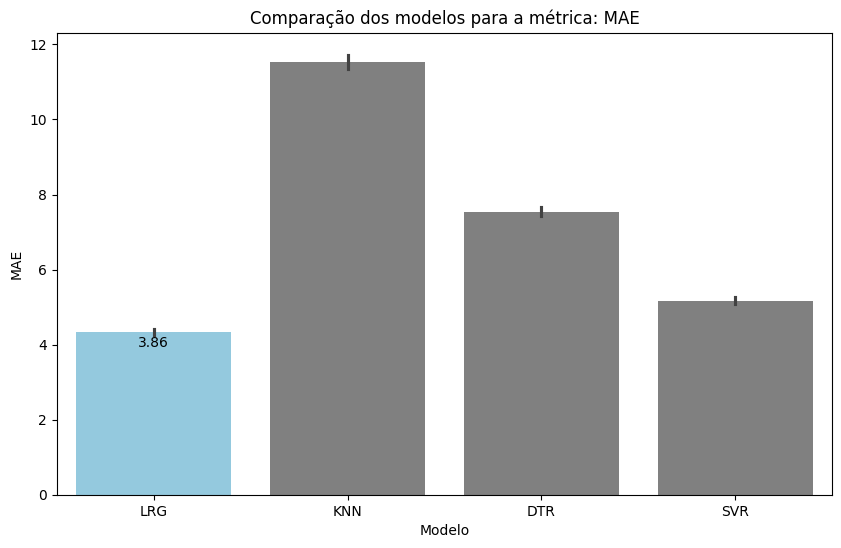

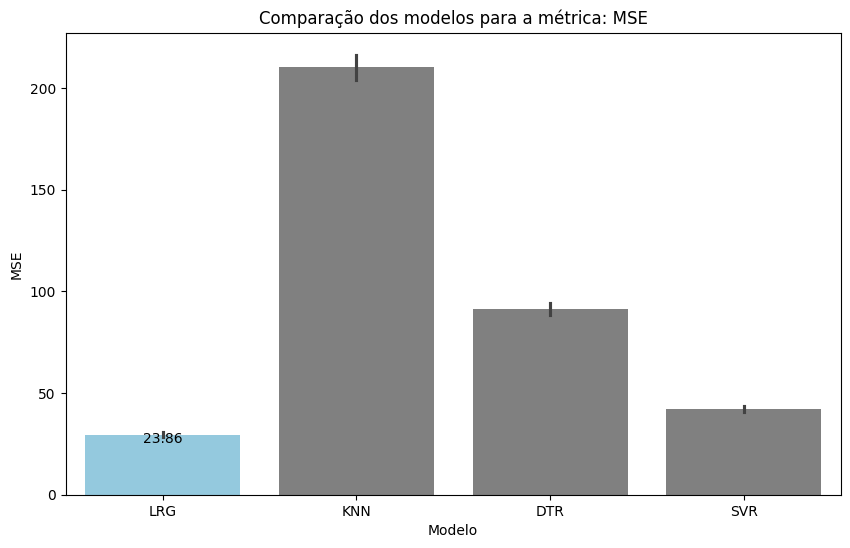

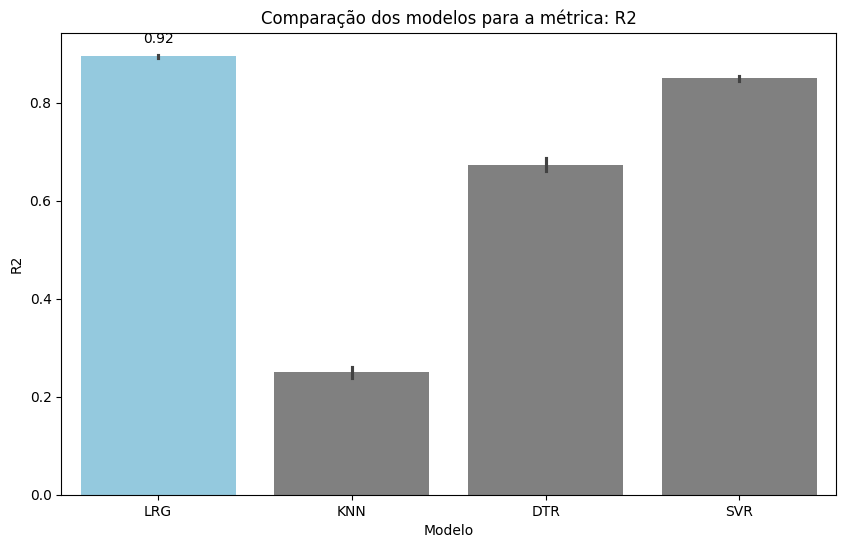

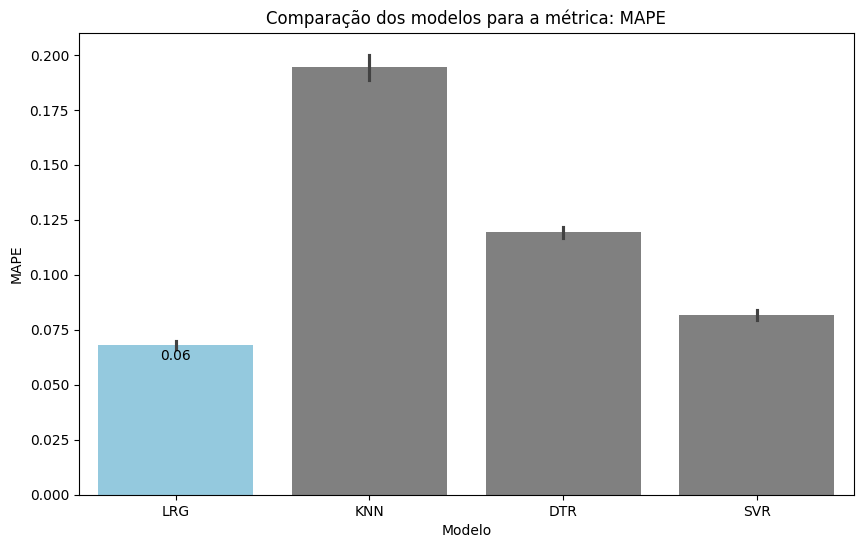

In [ ]:
# @title Comparative Charts
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe to have a long format suitable for seaborn
melted_results = final_results.melt(id_vars=['modelo'],
                                    value_vars=[f'test_{metric}' for metric in metrics.keys()],
                                    var_name='métrica',
                                    value_name='valor')

# Map the internal metric names to the user-friendly names
metric_name_mapping = {f'test_{name}': value for name, value in metrics.items()}
melted_results['métrica'] = melted_results['métrica'].map(metric_name_mapping)

# Create a bar plot for each metric
for metric_name in metrics.values():
    plt.figure(figsize=(10, 6))

    # Determine the best performing model for the current metric
    if metric_name == 'R2':
        # For R2, higher is better
        best_model = melted_results[melted_results['métrica'] == metric_name].loc[melted_results[melted_results['métrica'] == metric_name]['valor'].idxmax()]
    else:
        # For MAE, MSE, MAPE, lower is better
        best_model = melted_results[melted_results['métrica'] == metric_name].loc[melted_results[melted_results['métrica'] == metric_name]['valor'].idxmin()]

    # Create a list of colors with the best model's bar highlighted
    colors = ['gray' if modelo != best_model['modelo'] else 'skyblue' for modelo in melted_results[melted_results['métrica'] == metric_name]['modelo'].unique()]

    # Use barplot, assigning x to hue and setting legend=False
    ax = sns.barplot(x='modelo', y='valor', data=melted_results[melted_results['métrica'] == metric_name], palette=colors, hue='modelo', legend=False)

    # Add annotation for the best performing model
    ax.text(ax.patches[list(melted_results[melted_results['métrica'] == metric_name]['modelo'].unique()).index(best_model['modelo'])].get_x() + ax.patches[list(melted_results[melted_results['métrica'] == metric_name]['modelo'].unique()).index(best_model['modelo'])].get_width()/2.,
            best_model['valor'],
            f'{best_model["valor"]:.2f}',
            ha='center', va='bottom', fontsize=10, color='black')

    plt.title(f'Comparação dos modelos para a métrica: {metric_name}')
    plt.ylabel(metric_name)
    plt.xlabel('Modelo')
    plt.show()
    print("\n")

In [ ]:

# @title Analysis of the importance of each feature in the linear regression model

# Treinar o pipeline com o modelo LRG em todo o conjunto de dados
lrg_full_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("model", LinearRegression())
])

lrg_full_pipeline.fit(X, y)

# Acessar o modelo LinearRegression treinado dentro do pipeline
trained_lrg_model = lrg_full_pipeline.named_steps['model']

# Obter os nomes das features após o pré-processamento
# Isso é um pouco mais complexo pois o ColumnTransformer pode gerar novas colunas (OneHotEncoder)
# Uma forma é inspecionar as colunas resultantes após a transformação do X
X_processed = lrg_full_pipeline.named_steps['preprocessing'].transform(X)

# Para modelos lineares, o número de coeficientes deve corresponder ao número de features após o pré-processamento.
# Podemos tentar obter os nomes das features transformadas, mas depende da versão do scikit-learn e da complexidade do ColumnTransformer.

# Uma abordagem mais simples e robusta é criar um DataFrame com os coeficientes e tentar mapeá-los de volta,
# mas a interpretação exata dos coeficientes para variáveis OneHotEncoded requer cuidado.

# Vamos começar exibindo os coeficientes diretamente.
print("Coeficientes do modelo Linear Regression:")
print(trained_lrg_model.coef_)

# Para tentar obter os nomes das features, podemos inspecionar o ColumnTransformer
# Isso pode variar dependendo das transformações (ex: OneHotEncoder cria várias colunas para uma nominal)

# Exemplo básico para tentar obter nomes (pode não funcionar perfeitamente com todas as transformações):
try:
    feature_names = lrg_full_pipeline.named_steps['preprocessing'].get_feature_names_out()
    print("\nNomes das features (após pré-processamento):")
    print(feature_names)

    # Criar um DataFrame para melhor visualização dos coeficientes e nomes das features
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': trained_lrg_model.coef_[0]})
    # Ordenar por valor absoluto do coeficiente para ver as mais importantes
    coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

    print("\nImportância das Features (baseado nos coeficientes do LRG):")
    display(coef_df[['Feature', 'Coefficient']])

except Exception as e:
    print("\nNão foi possível obter os nomes das features de forma programática com facilidade.")
    print("Os coeficientes correspondem às features na ordem em que foram processadas pelo ColumnTransformer.")
    print(f"Erro: {e}")

Coeficientes do modelo Linear Regression:
[[-2.81296649e-01 -1.08177791e-02 -2.49625670e-01 -2.85034183e-01
  -1.40145291e-01  4.25179474e-01  2.25956340e-01 -4.33679274e-02
  -1.01261338e-01  8.69139522e+00  1.75193350e+01  7.95394096e+01
  -1.88335164e+01 -1.23076343e+01  6.29498855e+00  1.35717906e+01]]

Nomes das features (após pré-processamento):
['ordinal__diet_quality' 'ordinal__parental_education_level'
 'ordinal__internet_quality' 'nominal__gender_Female'
 'nominal__gender_Male' 'nominal__gender_Other'
 'nominal__part_time_job_Yes' 'nominal__extracurricular_participation_Yes'
 'discrete__age' 'discrete__exercise_frequency'
 'discrete__mental_health_rating' 'continuous__study_hours_per_day'
 'continuous__social_media_hours' 'continuous__netflix_hours'
 'continuous__attendance_percentage' 'continuous__sleep_hours']

Importância das Features (baseado nos coeficientes do LRG):


,Feature,Coefficient
11,continuous__study_hours_per_day,79.539410
12,continuous__social_media_hours,-18.833516
10,discrete__mental_health_rating,17.519335
15,continuous__sleep_hours,13.571791
13,continuous__netflix_hours,-12.307634
9,discrete__exercise_frequency,8.691395
14,continuous__attendance_percentage,6.294989
5,nominal__gender_Other,0.425179
3,nominal__gender_Female,-0.285034
0,ordinal__diet_quality,-0.281297


# Conclusion

Based on the comparative analysis of the models and the investigation of the coefficients of the Linear Regression (LRG) model, we can conclude that LRG is the most appropriate model for predicting the continuous variable “exam score” in this dataset.

LRG demonstrated the best balance between accuracy (evidenced by lower MAE and MSE, and higher R²) and interpretability compared to the KNN, DTR, and SVR models.

Analysis of the LRG model coefficients offers valuable insights into the linear relationship between the input variables and the exam score:

* The feature with the greatest positive impact on exam score is **`continuous__study_hours_per_day`**, with a coefficient of approximately **79.54**. This strongly suggests that **increasing daily study hours is associated with a significant increase in exam score**.
* On the other hand, the feature with the greatest negative impact is **`continuous__social_media_hours`**, with a coefficient of approximately **-18.83**. This indicates that **more time spent on social media is associated with a notable decrease in exam scores**.
* Other features that show an important relationship (considering the absolute value of the coefficient) include **`discrete__mental_health_rating`*  (approximately 17.52), **`continuous__sleep_hours`** (approximately 13.57), and **`continuous__netflix_hours`** (approximately -12.31). Apparently, better mental health and more hours of sleep are positively associated with grades, while more hours on Netflix are negatively associated.

These results reinforce the idea that student performance in this dataset is influenced by factors that have approximately linear relationships with the final grade, and Linear Regression is able to capture these relationships in an effective and interpretable way.